In [1]:
 from google.colab import drive
 import os
 drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
os.chdir('/content/drive/MyDrive/5153 Project/Dataset')

In [3]:
!pip install transformers==4.17.0 -q
import pandas as pd
import numpy as np
import torch
from transformers import BertTokenizer, BertModel

In [4]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [5]:

data  = pd.read_csv('/content/drive/MyDrive/5153 Project/Dataset/train (1).csv')

In [6]:
data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [7]:
import matplotlib.pyplot as plt 
##### models ##########################################################################################
import lightgbm as lgb
from sklearn.svm import SVC 
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from transformers import DistilBertTokenizer, DistilBertModel
#### Scoring###########################################################################################
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_validate
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import auc, roc_auc_score, roc_curve
from sklearn.metrics import f1_score

#### Tuning Hyper-parameters###########################################################################
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_selection import SequentialFeatureSelector
from imblearn.over_sampling import SMOTE

# Load pre-trained model tokenizer (vocabulary)
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
# Load pre-trained model (weights)
model = DistilBertModel.from_pretrained('distilbert-base-uncased')
# # Load pre-trained model tokenizer (vocabulary)
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# # Load pre-trained model tokenizer (vocabulary)
# model = BertModel.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [8]:
tokenized = data['text'].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))

In [9]:
length = 0
for sen in tokenized:
    if len(sen) > length:
        length = len(sen) 
print(length)

84


In [10]:
padded_text =pad_sequences(tokenized, maxlen=20, truncating='post',padding='post')

In [11]:
padded_text.shape

(7613, 20)

In [12]:
attention_mask = np.where(padded_text != 0, 1, 0)
attention_mask.shape

(7613, 20)

In [13]:
X = torch.tensor(padded_text)  
X_mask = torch.tensor(attention_mask)

In [14]:
Y = torch.tensor(data['target'])

In [15]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=42)
train_masks, test_masks, _, _ = train_test_split(X_mask, Y, test_size=0.25, random_state=42)

In [16]:
train_list = list(range(0,len(X_train),200))
test_list = list(range(0,len(X_test),200))

In [17]:
train_tensor_list = []
for i in train_list:
    print(i)
    model_outputs =   model(X_train[i:i+200], attention_mask=train_masks[i:i+200])
    train_tensor_list.append(model_outputs[0][:,0,-40:])

0
200
400
600
800
1000
1200
1400
1600
1800
2000
2200
2400
2600
2800
3000
3200
3400
3600
3800
4000
4200
4400
4600
4800
5000
5200
5400
5600


In [18]:
train_embedding = torch.cat(train_tensor_list,0)
train_embedding.shape

torch.Size([5709, 40])

In [19]:
#torch.save(train_embedding,'train_embedding.pt')

In [20]:
test_tensor_list = []
for i in test_list:
    print(i)
    model_outputs =   model(X_test[i:i+200], attention_mask=test_masks[i:i+200])
    test_tensor_list.append(model_outputs[0][:,0,-40:])

0
200
400
600
800
1000
1200
1400
1600
1800


In [21]:
test_embedding = torch.cat(test_tensor_list,0)
test_embedding.shape

torch.Size([1904, 40])

In [22]:
#torch.save(test_embedding,'test_embedding.pt')

In [23]:
###########################define function to get confusion matrix and ROC CURVE ######################################
def get_conf_auc(X_test,y_test,y_predicted, prob_y,model):  
    y_predicted=model.predict(X_test)
    y_predicted = pd.DataFrame(y_predicted,columns=['model_result'])
    prob_y=model.predict_proba(X_test)[:,1]  
    
    # Calculate class probabilities, generate ROC curve, and compute AUC
    fpr, tpr, thresholds = roc_curve(y_test, prob_y)
    classifier_roc_auc = roc_auc_score(y_test, prob_y)

    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label='Classifier (area = %0.2f)' % classifier_roc_auc)

    # Plot Base Rate ROC
    plt.plot([0,1], [0,1],label='Baseline', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.title('ROC Curve',fontsize = "20")
    plt.legend(loc="lower right")
    plt.show()
    
    ################################ Confusion matrix- ####################################################################
    cm = confusion_matrix(y_test, y_predicted, labels=GS2.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=GS2.classes_)
    disp.plot()

    auc = roc_auc_score(y_test, prob_y)
    accuracy = accuracy_score(y_test, (y_predicted >0.5))
    f1 = f1_score(y_test, y_predicted )

    print('AUC:%.3f'%auc)
    print('accuracy:%.3f'%accuracy)
    print('f1:%.3f'%f1)
    print(' ')
    return auc, accuracy, f1

In [24]:
train_embedding = train_embedding.detach().numpy()
test_embedding = test_embedding.detach().numpy()


In [25]:
sm = SMOTE()
train_embedding, y_train = sm.fit_resample(train_embedding, y_train)

In [26]:
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier(random_state=42)
search_space = {    'max_depth': [12,15,20],
               'learning_rate': [0.3,0.4,0.5],
                "n_estimators" : [ 1500,2000,2500]3
                
              }

GS2= RandomizedSearchCV(gb, search_space, n_iter=60, scoring= 'accuracy', n_jobs=-1, cv=5, verbose=5)
GS2.fit(train_embedding , y_train)
print(GS2.best_estimator_)
print(GS2.best_score_)
GS2.score(test_embedding, y_test)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:296: UserWarning: The total space of parameters 27 is smaller than n_iter=60. Running 27 iterations. For exhaustive searches, use GridSearchCV.
  UserWarning,


GradientBoostingClassifier(learning_rate=0.3, max_depth=12, n_estimators=1500,
                           random_state=42)
0.789609294625436


0.7536764705882353

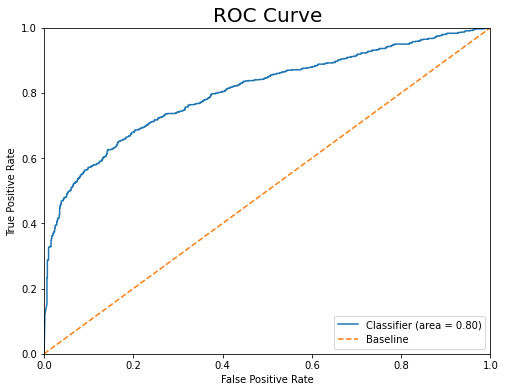

AUC:0.804
accuracy:0.754
f1:0.693
 


(0.80398778781555, 0.7536764705882353, 0.6932635709614128)

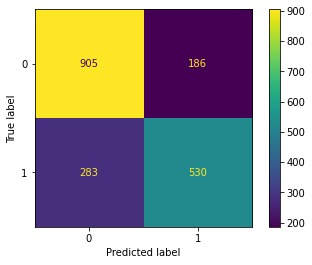

In [27]:
y_predicted_XGB=0
prob_y=0
get_conf_auc(test_embedding,y_test,y_predicted_XGB, prob_y,GS2)

In [28]:
lgb_clf = lgb.LGBMClassifier(random_state=42)

search_space = {    'max_depth': [12,15,20],
               'learning_rate': [0.3,0.4,0.5],
                "n_estimators" : [ 1500,2000,2500]
              }

GS3= RandomizedSearchCV(lgb_clf, search_space, n_iter=60, scoring= 'accuracy', n_jobs=-1, cv=5, verbose=5)
GS3.fit(train_embedding , y_train)
print(GS3.best_estimator_)
print(GS3.best_score_)
GS3.score(test_embedding, y_test)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:296: UserWarning: The total space of parameters 27 is smaller than n_iter=60. Running 27 iterations. For exhaustive searches, use GridSearchCV.
  UserWarning,


LGBMClassifier(learning_rate=0.3, max_depth=12, n_estimators=2500,
               random_state=42)
0.7813047951280081


0.7394957983193278

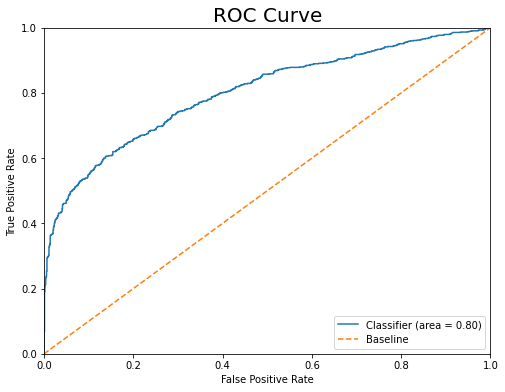

AUC:0.801
accuracy:0.739
f1:0.681
 


(0.8005474738523737, 0.7394957983193278, 0.6812339331619538)

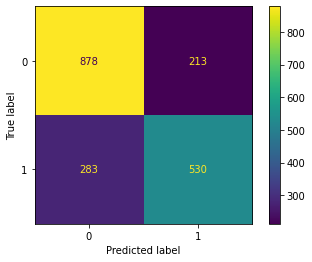

In [29]:
y_predicted_LGM=0
prob_y=0
get_conf_auc(test_embedding,y_test,y_predicted_LGM, prob_y,GS3)

In [30]:
#RF
rf = RandomForestClassifier()
search_space = {
     "n_estimators" : [ 1500,2000,2500],
    "max_depth" : [10, 20, 25]
}

GS= RandomizedSearchCV(rf, search_space, n_iter=60 ,scoring= 'accuracy', n_jobs=-1, cv=5, verbose=0)

GS.fit(train_embedding , y_train)
print(GS.best_estimator_)
print(GS.best_score_)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:296: UserWarning: The total space of parameters 9 is smaller than n_iter=60. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


RandomForestClassifier(max_depth=20, n_estimators=1500)
0.7856071660852599


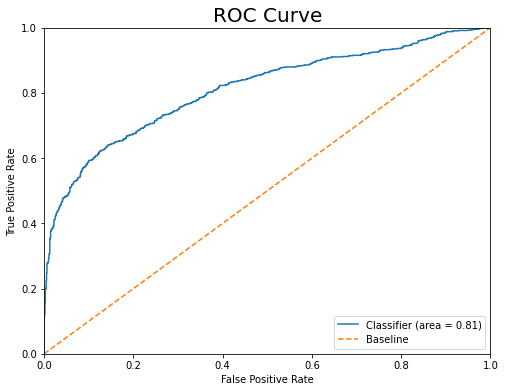

AUC:0.811
accuracy:0.762
f1:0.697
 


(0.8106953571827193, 0.7620798319327731, 0.6973947895791582)

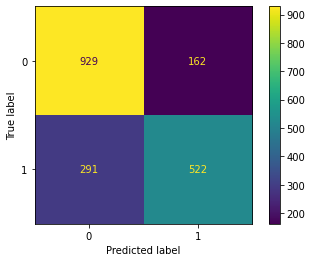

In [31]:
y_predicted_GS_RF=0
prob_y=0
get_conf_auc(test_embedding, y_test,y_predicted_GS_RF, prob_y,GS)